# Test using kerchunk on problematic atmos files from CM2 run

Building on Martin's notebook here: https://github.com/MartinDix/notebooks/blob/master/xarray_memory_usage.ipynb

In [1]:
%cd /g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake/kerchunk_cm2_atmosphere

/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake/kerchunk_cm2_atmosphere


In [2]:
import fsspec
import fsspec.implementations.reference

import xarray as xr

from distributed import Client

import cosima_cookbook as cc

%load_ext memory_profiler

In [3]:
import sys
sys.path.insert(1, "/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake")
from kerchunk_utils import create_reference

# Create kerchunk reference dataset

In [4]:
fs = fsspec.filesystem('file')

files = sorted(fs.glob("/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/atm/netCDF/*_mon.nc"))

In [ ]:
create_reference(
    (
        files,
        dict(
            concat_dims=["time"],
            identical_dims=[
                "model_theta_level_number", 
                "lat", 
                "lon", 
                "bnds", 
                "model_rho_level_number", 
                "pseudo_level", 
                "pseudo_level_0", 
                "lon_u", 
                "lat_v", 
                "pseudo_level_1", 
                "pseudo_level_2", 
                "depth",
                "pressure",
             ]
        )
    ),
    filename="cj877.atm"
)

# Compare performance
## These cells are taken from Martin's notebook

In [5]:
def annual_mean(ds):
    """ Properly month length weighted annual mean of a DataArray"""
    month_length = ds.time.dt.days_in_month
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    ann_mean = (ds*weights).groupby('time.year').sum(dim='time',min_count=1)
    return ann_mean

def global_mean(ds,weights):
    """ Area weighted global mean of a DataArray"""
    ds_w = ds.weighted(weights.fillna(0))
    return ds_w.mean(['yt_ocean', 'xt_ocean'])

def atm_global_mean(ds,weights):
    """ Area weighted global mean of a DataArray"""
    ds_w = ds.weighted(weights.fillna(0))
    return ds_w.mean(['lat', 'lon'])

In [6]:
session = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt = 'cj877'

### Ocean data using cosima-cookbook

In [7]:
%%time
%%memit

sst = cc.querying.getvar(
    expt, 
    'surface_pot_temp', 
    session, 
    end_time='0010-12-31', 
    frequency='1 monthly', 
    use_cftime=True
)

area_t = cc.querying.getvar(expt, 'area_t', session, n=1)

peak memory: 195.00 MiB, increment: 43.53 MiB
CPU times: user 3.61 s, sys: 762 ms, total: 4.37 s
Wall time: 4.8 s


peak memory: 571.93 MiB, increment: 376.89 MiB
CPU times: user 6.25 s, sys: 560 ms, total: 6.81 s
Wall time: 5.05 s


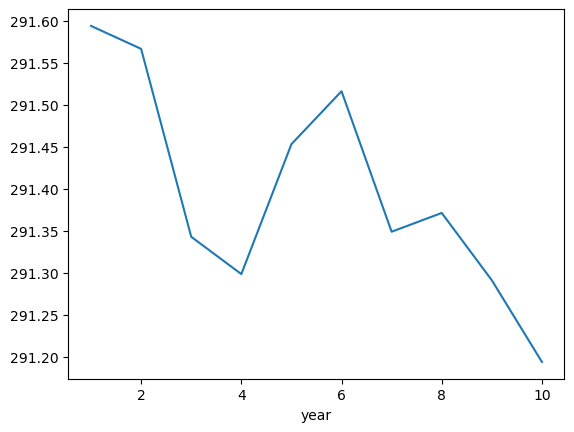

In [8]:
%%time
%%memit

# This order is slightly faster and uses less memory than the alternative of 
# annual mean and then global mean
sst_g = global_mean(sst, area_t)
sst_a = annual_mean(sst_g)
sst_a.load()
sst_a.plot()

### Atmosphere data using cosima-cookbook

In [7]:
%%time
%%memit

tas = cc.querying.getvar(
    expt, 
    'fld_s03i236', 
    session, 
    end_time='0010-12-31', 
    use_cftime=True
)

area_a = xr.open_dataset(
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/'
    'r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc'
).areacella

peak memory: 1891.95 MiB, increment: 1740.50 MiB
CPU times: user 59.6 s, sys: 24.9 s, total: 1min 24s
Wall time: 54 s


peak memory: 1910.34 MiB, increment: 18.38 MiB
CPU times: user 1.15 s, sys: 268 ms, total: 1.42 s
Wall time: 1.48 s


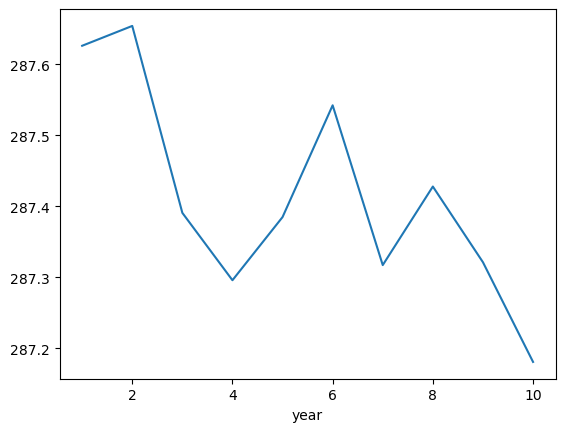

In [8]:
%%time
%%memit

tas_g = atm_global_mean(tas, area_a)
tas_a = annual_mean(tas_g)
tas_a.load()
tas_a.plot()

# Atmosphere data using kerchunk reference file

In [7]:
%%time
%%memit

m = fsspec.implementations.reference.DFReferenceFileSystem(
    "cj877.atm.parq", lazy=True
).get_mapper()

tas = xr.open_dataset(
    m,
    engine='zarr', 
    backend_kwargs={"consolidated": False},
    use_cftime=True,
    inline_array=True,
    chunks={"time": 120},
)["fld_s03i236"].sel(time=slice(None, '0010-12-31'))

area_a = xr.open_dataset(
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/'
    'r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc'
).areacella

peak memory: 161.04 MiB, increment: 9.43 MiB
CPU times: user 609 ms, sys: 102 ms, total: 710 ms
Wall time: 957 ms


peak memory: 197.51 MiB, increment: 36.42 MiB
CPU times: user 686 ms, sys: 272 ms, total: 958 ms
Wall time: 1.25 s


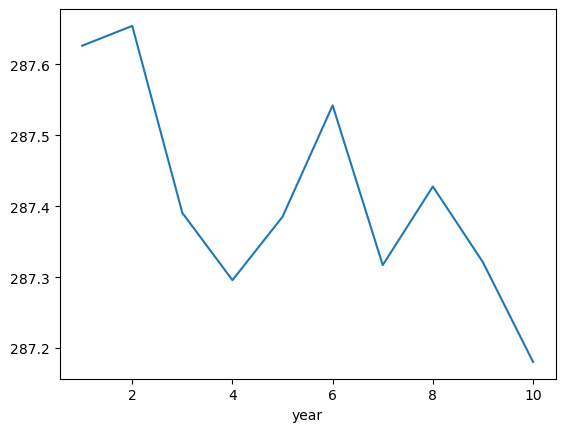

In [8]:
%%time
%%memit

tas_g = atm_global_mean(tas, area_a)
tas_a = annual_mean(tas_g)
tas_a.load()
tas_a.plot()